# **Problem #1**
<br> This problem is solved using logistic regression.Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous.  Like all regression analyses, the logistic regression is a predictive analysis.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.


**Setting 1**<br>
Number of iteration = 10000<br>
Learning rate = 0.001
<br>batch size = 300<br>
optimizer = SGD<br>
epoch = 54



In [ ]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset was downloaded form https://www.kaggle.com/BengaliAI/numta/ 

In [ ]:
!unzip '/content/drive/MyDrive/dd.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dataset/training-e/e11779.png  
  inflating: dataset/training-e/e11780.png  
  inflating: dataset/training-e/e11781.png  
  inflating: dataset/training-e/e11782.png  
  inflating: dataset/training-e/e11783.png  
  inflating: dataset/training-e/e11784.png  
  inflating: dataset/training-e/e11785.png  
  inflating: dataset/training-e/e11786.png  
  inflating: dataset/training-e/e11787.png  
  inflating: dataset/training-e/e11788.png  
  inflating: dataset/training-e/e11789.png  
  inflating: dataset/training-e/e11790.png  
  inflating: dataset/training-e/e11791.png  
  inflating: dataset/training-e/e11792.png  
  inflating: dataset/training-e/e11793.png  
  inflating: dataset/training-e/e11794.png  
  inflating: dataset/training-e/e11795.png  
  inflating: dataset/training-e/e11796.png  
  inflating: dataset/training-e/e11797.png  
  inflating: dataset/training-e/e11798.png  
  inflating: dataset/training-e/e11799.png  
  in

In [ ]:
PATH = '/content/dataset'
os.listdir(PATH)

['testing-f',
 'training-a',
 'testing-auga',
 'training-b',
 'testing-a',
 'training-b.csv',
 'training-a.csv',
 'training-c',
 'testing-e',
 'training-e',
 'training-c.csv',
 'training-d',
 'testing-b',
 'testing-augc',
 'training-d.csv',
 'training-e.csv',
 'testing-d',
 'testing-c',
 'testing-all-corrected']

In [ ]:
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(PATH + csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

In [ ]:
a_csv = showRawTrainingSamples('/training-a.csv')

c_csv = showRawTrainingSamples('/training-c.csv')
d_csv = showRawTrainingSamples('/training-d.csv')


/training-a.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
/training-c.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
/training-d.csv
Index(['original filename', 'scanid', 'digit', 'num', 'database name original',
       'database name', 'filename'],
      dtype='object')


In [ ]:
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print(csv_file)
  print(csv_file.iloc[:5, :])   #First 5 Rows of the CSV File
  print("=============================")
  return csv_file

In [ ]:
a_csv = dropColumns(a_csv)

c_csv = dropColumns(c_csv)
d_csv = dropColumns(d_csv)


         filename  digit
0      a00000.png      5
1      a00001.png      3
2      a00002.png      1
3      a00003.png      7
4      a00004.png      0
...           ...    ...
19697  a19697.png      4
19698  a19698.png      3
19699  a19699.png      8
19700  a19700.png      3
19701  a19701.png      8

[19702 rows x 2 columns]
     filename  digit
0  a00000.png      5
1  a00001.png      3
2  a00002.png      1
3  a00003.png      7
4  a00004.png      0
         filename  digit
0      c00000.png      6
1      c00001.png      1
2      c00002.png      3
3      c00003.png      2
4      c00004.png      7
...           ...    ...
24293  c24293.png      3
24294  c24294.png      2
24295  c24295.png      7
24296  c24296.png      2
24297  c24297.png      7

[24298 rows x 2 columns]
     filename  digit
0  c00000.png      6
1  c00001.png      1
2  c00002.png      3
3  c00003.png      2
4  c00004.png      7
         filename  digit
0      d00000.png      1
1      d00001.png      1
2      d00002.png    

In [ ]:
total_csv = [a_csv,c_csv, d_csv]
merged_csv = pd.concat(total_csv)
print(len(merged_csv))

54908


In [ ]:
TRAIN_PATH = 'trains'
os.mkdir(TRAIN_PATH)

In [ ]:
def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH)  



In [ ]:
processImages('/training-a')
print('A Done')

processImages('/training-c')
print('C Done')
processImages('/training-d')
print('D Done')


A Done
C Done
D Done


**Snapshot from NumtaDB**
<div align="center">
<img src="https://drive.google.com/uc?id=1LvkNwV1My2RniR_JsbasBET1fa97eMQu" width="500">
</div>

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(merged_csv, TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv, TRAIN_PATH, test_transform)

print("Trainig Samples: ",len(train_data))

Trainig Samples:  54908


**Batch size :** <br>Total number of trainig examples present in a single batch

In [ ]:
batch_size = 300
test_size = 0.1

num_train = len(train_data)

indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))

train_idx, test_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)


train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:165
Test dataloader:19


In [ ]:
num_iters = 10000
input_dim = 28*28 # num_features = 784
output_dim = 10

learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Iterations:**<br> Iteration is the number of batches needed to complete one epoch.<br> **Epochs:**<br>One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only once.

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
num_epochs
#len(train_data)

54

**Designing your model using class**

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

**optimizer class**
<br>
**Stochastic gradient descent**
<br>
Stochastic gradient descent is an iterative method for optimizing an objective function with suitable smoothness properties. It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in high-dimensional optimization problems this reduces the computational burden, achieving faster iterations in trade for a lower convergence rate.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

**Forward propagation**<br>
The input data is fed in the forward direction through the network. Each hidden layer accepts the input data, processes it as per the activation function and passes to the successive layer.<br>
**Backpropagation**<br>Backpropagation refers to the method of calculating the gradient of neural network parameters. In short, the method traverses the network in reverse order, from the output to the input layer, according to the chain rule from calculus.<br>
**Loss**<br>The loss function is one of the important components of neural networks. Loss is noting but a prediction error of neural net. And the method to
calculate the loss is called loss function.



In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2912681102752686. Accuracy: 12.349726775956285
Iteration: 1000. Loss: 2.285869836807251. Accuracy: 15.901639344262295
Iteration: 1500. Loss: 2.268324613571167. Accuracy: 17.959927140255008
Iteration: 2000. Loss: 2.259767532348633. Accuracy: 22.823315118397087
Iteration: 2500. Loss: 2.2647476196289062. Accuracy: 25.555555555555557
Iteration: 3000. Loss: 2.2546465396881104. Accuracy: 27.249544626593806
Iteration: 3500. Loss: 2.231659412384033. Accuracy: 29.617486338797814
Iteration: 4000. Loss: 2.2139275074005127. Accuracy: 29.927140255009107
Iteration: 4500. Loss: 2.2163145542144775. Accuracy: 30.837887067395265
Iteration: 5000. Loss: 2.211426258087158. Accuracy: 32.80510018214936
Iteration: 5500. Loss: 2.197911024093628. Accuracy: 31.602914389799636
Iteration: 6000. Loss: 2.2031233310699463. Accuracy: 34.42622950819672
Iteration: 6500. Loss: 2.193699359893799. Accuracy: 34.025500910746814
Iteration: 7000. Loss: 2.1943817138671875. Accuracy: 34.80874316939891
Ite

[2.2912681102752686, 2.285869836807251, 2.268324613571167, 2.259767532348633, 2.2647476196289062, 2.2546465396881104, 2.231659412384033, 2.2139275074005127, 2.2163145542144775, 2.211426258087158, 2.197911024093628, 2.2031233310699463, 2.193699359893799, 2.1943817138671875, 2.1806912422180176, 2.186958074569702, 2.149998664855957]


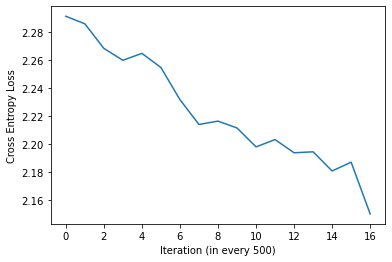

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

root_path = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path+ '1.1_settings01.pkl') 

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + '1.1_settings01.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


**Setting 2**<br>
Number of iteration = 10000<br>
Learning rate = 0.0001
<br>batch size = 300<br>
optimizer = adam <br>
epoch = 54

In [ ]:
batch_size = 300
test_size = 0.1

num_train = len(train_data)

indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))

train_idx, test_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)


train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:165
Test dataloader:19


In [ ]:
num_iters = 10000
input_dim = 28*28 # num_features = 784
output_dim = 10

learning_rate = 0.0001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
num_epochs
#len(train_data)

54

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

**Adam**<br>
Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2387535572052. Accuracy: 24.918032786885245
Iteration: 1000. Loss: 2.182298183441162. Accuracy: 29.162112932604735
Iteration: 1500. Loss: 2.169280767440796. Accuracy: 32.05828779599271
Iteration: 2000. Loss: 2.088071584701538. Accuracy: 35.318761384335154
Iteration: 2500. Loss: 2.077920913696289. Accuracy: 37.15846994535519
Iteration: 3000. Loss: 2.1217432022094727. Accuracy: 35.810564663023676
Iteration: 3500. Loss: 2.0378575325012207. Accuracy: 38.032786885245905
Iteration: 4000. Loss: 2.023123025894165. Accuracy: 38.37887067395264
Iteration: 4500. Loss: 2.0403120517730713. Accuracy: 39.45355191256831
Iteration: 5000. Loss: 1.995512843132019. Accuracy: 39.36247723132969
Iteration: 5500. Loss: 1.9689860343933105. Accuracy: 39.56284153005465
Iteration: 6000. Loss: 1.9488266706466675. Accuracy: 39.435336976320585
Iteration: 6500. Loss: 1.9918071031570435. Accuracy: 40.34608378870674
Iteration: 7000. Loss: 1.9334845542907715. Accuracy: 40.81967213114754
Iteration:

[2.2387535572052, 2.182298183441162, 2.169280767440796, 2.088071584701538, 2.077920913696289, 2.1217432022094727, 2.0378575325012207, 2.023123025894165, 2.0403120517730713, 1.995512843132019, 1.9689860343933105, 1.9488266706466675, 1.9918071031570435, 1.9334845542907715, 1.945645809173584, 1.9311180114746094, 1.9189547300338745]


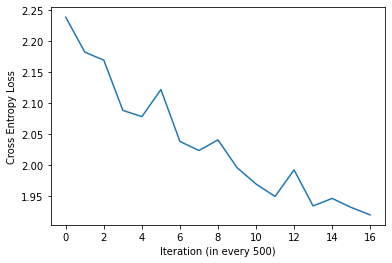

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

root_path = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path+ '1.1_settings02.pkl') 

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + '1.1_settings02.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


**Setting 3**<br>
Number of iteration = 5000<br>
Learning rate = 0.0001
<br>batch size = 350<br>
optimizer = adagrad<br>
epoch = 31

In [ ]:
batch_size = 350
test_size = 0.1

num_train = len(train_data)

indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))

train_idx, test_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)


train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:142
Test dataloader:16


In [ ]:
num_iters = 5000
input_dim = 28*28 # num_features = 784
output_dim = 10

learning_rate = 0.0001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
num_epochs
#len(train_data)

31

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

**Adagrad**<br>
Adagrad  is an algorithm for gradient-based optimization that does just this: It adapts the learning rate to the parameters, performing smaller updates
(i.e. low learning rates) for parameters associated with frequently occurring features, and larger updates  for parameters associated with infrequent features.

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3028945922851562. Accuracy: 11.602914389799636
Iteration: 1000. Loss: 2.2968077659606934. Accuracy: 11.857923497267759
Iteration: 1500. Loss: 2.3041749000549316. Accuracy: 12.950819672131148
Iteration: 2000. Loss: 2.2920429706573486. Accuracy: 13.151183970856103
Iteration: 2500. Loss: 2.2926433086395264. Accuracy: 13.734061930783243
Iteration: 3000. Loss: 2.286900043487549. Accuracy: 13.952641165755919
Iteration: 3500. Loss: 2.291522979736328. Accuracy: 14.171220400728597
Iteration: 4000. Loss: 2.285658597946167. Accuracy: 15.100182149362476


[2.3028945922851562, 2.2968077659606934, 2.3041749000549316, 2.2920429706573486, 2.2926433086395264, 2.286900043487549, 2.291522979736328, 2.285658597946167]


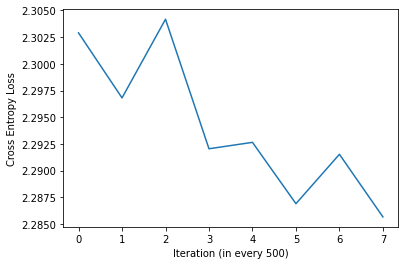

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()


| Observation | Optimizer     | Batch size     | Iteration     |Learning rate     |Epoch     |   Accuracy  |
| :------------- | :----------: | -----------: |-----------: |-----------: |-----------: |-----------: |
|  Setting 1 | SGD   | 300    |10000    |0.001    |54   | 34.53  |
| Setting 2   | Adam   | 300    |10000    |0.0001    |54    | 40.61 |
| Setting 3   |  Adagrad   | 350    |5000    |0.001    |31  | 15.10|